<a href="https://colab.research.google.com/github/SamuelLiuCh/Options/blob/main/%E6%B3%A2%E5%8B%95%E7%8E%87%E9%A0%90%E6%B8%AC%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 0: Import 套件

In [130]:
#下載資料套件
import urllib3
import requests
import json
from bs4 import BeautifulSoup

#資料處理套件
import math
from math import exp, log, sqrt
import numpy as np
import scipy
from scipy import stats
import pandas as pd
from datetime import datetime, date

#畫圖套件
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [131]:
!pip install arch
from arch import arch_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
'''
r = requests.get("https://www.macromicro.me/charts/14588/taiwan-10-year-government-bond-yield") #將網頁資料GET下來
#print(r.text)
sp = BeautifulSoup(r.text,"html.parser") #將網頁資料以html.parser
sel = sp.select("div span.val") #取HTML標中的 <div class="title"></div> 中的<a>標籤存入sel
for s in sel:
    print(s.text)'''

'\nr = requests.get("https://www.macromicro.me/charts/14588/taiwan-10-year-government-bond-yield") #將網頁資料GET下來\n#print(r.text)\nsp = BeautifulSoup(r.text,"html.parser") #將網頁資料以html.parser\nsel = sp.select("div span.val") #取HTML標中的 <div class="title"></div> 中的<a>標籤存入sel\nfor s in sel:\n    print(s.text)'

#函式：搜集選擇權資訊

In [235]:
def get_option_info(id='TXO',sd='2023/02/01',ed='2023/02/15'): # 搜集選擇權資訊 
    # 下載選擇權資料
    http = urllib3.PoolManager()
    url = "https://www.taifex.com.tw/cht/3/dlOptDataDown"
    res = http.request(
         'POST',
          url,
          fields={
            'down_type': 1,
            'commodity_id': id,
            'queryStartDate': sd,
            'queryEndDate': ed
          }
    )
    html_doc = res.data

    # 使用BeautifulSoup解析資料
    soup = BeautifulSoup(html_doc, 'html.parser')
    soup_str = str(soup)
    lines = soup_str.split('\r\n')

    # 新增空dataframe並定義欄名
    df = pd.DataFrame(columns = lines[0].split(','))

    # 將資料一行一行填入dataframe
    for i in range(1, len(lines) - 1):
        list_ = lines[i].split(',')[:-1]
        df_length = len(df)
        df.loc[df_length] = list_
    
    # 將資料轉型成可用數據
    for col in [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)
            if col == 0:
                try:
                    day = df.iloc[row,0].split('/')
                    df.iloc[row, 0] = datetime(int(day[0]), int(day[1]), int(day[2]))
                except:
                    pass
            # 把字串(string)換成浮點數(float): "履約價", "開盤價", "最高價", "最低價", "收盤價", "成交量", "結算價", "未沖銷契約數", "最後最佳買價", "最後最佳賣價", "歷史最高價", "歷史最低價" 
            elif col != 0 and df.iloc[row, col] != '-':
                try:
                    df.iloc[row, col] = float(df.iloc[row,col])
                except:
                    pass
    #print(df)
    return df

In [237]:
option = get_option_info()

/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:842: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [245]:
option
#option.head()
#option.describe()
#option['到期月份(週別)'].unique()
#option['履約價'].unique()
#option['交易日期'].unique()

array(['202302W1', '202302W2', '202302  ', '202303  ', '202304  ',
       '202306  ', '202309  ', '202302W4', '202303W1'], dtype=object)

#函式：買權資料彙整

In [247]:
def get_call_option1(df,dd='202302  '):
    call_df = df.loc[(df['到期月份(週別)'] == dd) & \
                (df['買賣權'] == '買權') & \
                (df['交易時段'] == '一般')]
    
    # 取得 dataframe index
    index = call_df['履約價'].unique()
    idx = np.sort(index)

    # 取得 dataframe 欄位名稱
    dates = call_df['交易日期'].unique()
    
    # 建立 dataframe 包含 index 與欄位名稱
    call_t_df = pd.DataFrame(index = idx, columns = list(dates))

    # 取出各日期的未沖銷契約數 依序放入 dataframe 中
    for col in call_t_df.columns:
        call_t_df[col] = call_df.loc[call_df['交易日期'] == col].set_index('履約價')['收盤價']
    
    #空值填入 0
    call_t_df = call_t_df.replace({'-':0})
    call_t_df = call_t_df.fillna(0)

    return call_t_df

In [240]:
def get_call_option2(df,td=datetime(2023, 2, 8, 0, 0)):
    call_df = df.loc[(df['交易日期'] == td) & \
                (df['買賣權'] == '買權') & \
                (df['交易時段'] == '一般')]
    
    # 取得 dataframe index
    index = call_df['履約價'].unique()
    idx = np.sort(index)

    # 取得 dataframe 欄位名稱
    dates = call_df['到期月份(週別)'].unique()
    
    # 建立 dataframe 包含 index 與欄位名稱
    call_t_df = pd.DataFrame(index = idx, columns = list(dates))

    # 取出各日期的未沖銷契約數 依序放入 dataframe 中
    for col in call_t_df.columns:
        call_t_df[col] = call_df.loc[call_df['到期月份(週別)'] == col].set_index('履約價')['收盤價']
    
    #空值填入 0
    call_t_df = call_t_df.replace({'-':0})
    call_t_df = call_t_df.fillna(0)

    return call_t_df

In [246]:
def get_call_option3(df,dd='202302  '):
    call_df = df.loc[(df['到期月份(週別)'] == dd) & \
                (df['買賣權'] == '買權') & \
                (df['交易時段'] == '一般')]
    
    # 取得 dataframe index
    index = call_df['履約價'].unique()
    idx = np.sort(index)

    # 取得 dataframe 欄位名稱
    dates = call_df['交易日期'].unique()
    
    # 建立 dataframe 包含 index 與欄位名稱
    call_t_df = pd.DataFrame(index = idx, columns = list(dates))

    # 取出各日期的未沖銷契約數 依序放入 dataframe 中
    for col in call_t_df.columns:
        call_t_df[col] = call_df.loc[call_df['交易日期'] == col].set_index('履約價')['未沖銷契約數']
    
    #空值填入 0
    call_t_df = call_t_df.replace({'-':0})
    call_t_df = call_t_df.fillna(0)

    return call_t_df

In [249]:
call1 = get_call_option1(df=option)
call2 = get_call_option2(df=option)
call3 = get_call_option3(df=option)

In [250]:
call1

,2023-02-01,2023-02-02,2023-02-03,2023-02-06,2023-02-07,2023-02-08,2023-02-09,2023-02-10,2023-02-13,2023-02-14,2023-02-15
11900.0,3440.0,0.0,3690.0,3520.0,0.0,3640.0,0.0,0.0,0.0,3760.0,3500.0
12000.0,0.0,0.0,0.0,0.0,3420.0,0.0,0.0,0.0,0.0,3660.0,0.0
12100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3300.0
12200.0,0.0,0.0,0.0,0.0,0.0,3420.0,0.0,0.0,0.0,3470.0,0.0
12300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17700.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
17800.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17900.0,0.0,0.2,0.0,1.0,0.1,0.1,0.1,0.0,0.7,0.0,0.0
18000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0


In [141]:
call2

,202302W1,202302W2,202302,202303,202304,202306,202309
10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
18400.0,0.0,0.0,0.0,1.3,0.0,0.0,22.0
18600.0,0.0,0.0,0.0,0.8,0.0,0.0,30.5
18800.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0
19000.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0


In [251]:
call3

,2023-02-01,2023-02-02,2023-02-03,2023-02-06,2023-02-07,2023-02-08,2023-02-09,2023-02-10,2023-02-13,2023-02-14,2023-02-15
11900.0,851.0,851.0,851.0,851.0,851.0,851.0,851.0,851.0,851.0,803.0,84.0
12000.0,22.0,22.0,22.0,22.0,18.0,18.0,18.0,18.0,18.0,5.0,5.0
12100.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,24.0
12200.0,6.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,1.0,1.0
12300.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
17700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17800.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
17900.0,0.0,3.0,4.0,4.0,6.0,7.0,7.0,7.0,11.0,11.0,11.0
18000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#函式：賣權資料彙整

In [252]:
def get_put_option1(df,dd='202302  '):
    put_df = df.loc[(df['到期月份(週別)'] == dd) & \
                (df['買賣權'] == '賣權') & \
                (df['交易時段'] == '一般')]
    
    # 取得 dataframe index
    index = put_df['履約價'].unique()
    idx = np.sort(index)

    # 取得 dataframe 欄位名稱
    dates = put_df['交易日期'].unique()

    # 建立 dataframe 包含 index 與欄位名稱
    put_t_df = pd.DataFrame(index = idx, columns = list(dates))

    # 取出各日期的未沖銷契約數 依序放入 dataframe 中
    for col in put_t_df.columns:
        put_t_df[col] = put_df.loc[put_df['交易日期'] == col].set_index('履約價')['收盤價']
    
    #空值填入 0
    put_t_df = put_t_df.replace({'-':0})
    put_t_df = put_t_df.fillna(0)

    return put_t_df

In [253]:
def get_put_option2(df,td=datetime(2023, 2, 8, 0, 0)):
    put_df = df.loc[(df['交易日期'] == td) & \
                (df['買賣權'] == '賣權') & \
                (df['交易時段'] == '一般')]
    
    # 取得 dataframe index
    index = put_df['履約價'].unique()
    idx = np.sort(index)

    # 取得 dataframe 欄位名稱
    dates = put_df['到期月份(週別)'].unique()

    # 建立 dataframe 包含 index 與欄位名稱
    put_t_df = pd.DataFrame(index = idx, columns = list(dates))

    # 取出各日期的未沖銷契約數 依序放入 dataframe 中
    for col in put_t_df.columns:
        put_t_df[col] = put_df.loc[put_df['到期月份(週別)'] == col].set_index('履約價')['收盤價']
    
    #空值填入 0
    put_t_df = put_t_df.replace({'-':0})
    put_t_df = put_t_df.fillna(0)

    return put_t_df

In [254]:
def get_put_option3(df,dd='202302  '):
    put_df = df.loc[(df['到期月份(週別)'] == dd) & \
                (df['買賣權'] == '賣權') & \
                (df['交易時段'] == '一般')]
    
    # 取得 dataframe index
    index = put_df['履約價'].unique()
    idx = np.sort(index)

    # 取得 dataframe 欄位名稱
    dates = put_df['交易日期'].unique()

    # 建立 dataframe 包含 index 與欄位名稱
    put_t_df = pd.DataFrame(index = idx, columns = list(dates))
    
    # 取出各日期的未沖銷契約數 依序放入 dataframe 中
    for col in put_t_df.columns:
        put_t_df[col] = put_df.loc[put_df['交易日期'] == col].set_index('履約價')['未沖銷契約數']
    
    #空值填入 0
    put_t_df = put_t_df.replace({'-':0})
    put_t_df = put_t_df.fillna(0)

    return put_t_df

In [255]:
put1 = get_put_option1(df=option)
put2 = get_put_option2(df=option)
put3 = get_put_option3(df=option)

In [256]:
put1

,2023-02-01,2023-02-02,2023-02-03,2023-02-06,2023-02-07,2023-02-08,2023-02-09,2023-02-10,2023-02-13,2023-02-14,2023-02-15
11900.0,1.5,0.2,1.3,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
12000.0,1.5,1.3,0.3,0.0,0.2,0.0,0.0,0.0,0.2,0.0,0.0
12100.0,0.6,0.4,0.0,0.0,0.2,0.7,0.0,0.6,0.0,0.0,0.0
12200.0,0.7,0.4,0.3,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0
12300.0,0.6,0.3,0.5,0.0,0.6,0.0,0.0,0.6,0.0,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
17700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
put2

,202302W2,202302,202302W4,202303,202304,202306,202309
10000.0,0.0,0.0,0.0,0.6,0.0,21.0,0.0
10200.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0
10400.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10600.0,0.0,0.0,0.0,1.3,0.0,0.0,0.0
10800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
18400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
put3

,2023-02-01,2023-02-02,2023-02-03,2023-02-06,2023-02-07,2023-02-08,2023-02-09,2023-02-10,2023-02-13,2023-02-14,2023-02-15
11900.0,1056.0,1076.0,1079.0,1087.0,1083.0,1103.0,1103.0,1108.0,1108.0,1108.0,1108.0
12000.0,797.0,807.0,812.0,814.0,822.0,822.0,822.0,822.0,827.0,827.0,822.0
12100.0,203.0,203.0,203.0,203.0,203.0,204.0,204.0,204.0,204.0,204.0,204.0
12200.0,353.0,321.0,321.0,321.0,321.0,321.0,321.0,321.0,321.0,321.0,321.0
12300.0,164.0,131.0,131.0,131.0,131.0,131.0,131.0,131.0,131.0,131.0,131.0
...,...,...,...,...,...,...,...,...,...,...,...
17700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Part 1: 取用選擇權數據

#Part 2: Plotly繪圖

In [261]:
# Read data from df
z_data = put1
x_data = list(z_data.index)
y_data = list(z_data)

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(title='call', autosize=False,
                  xaxis={'tickmode':'array','tickvals':x_data,'ticktext':x_data},
                  yaxis={'tickmode':'array','tickvals':y_data,'ticktext':x_data},
                  width=1000, height=750,
                  margin=dict(l=50, r=50, b=50, t=50))

fig.update_xaxes(tickmode='array', tickvals=x_data, ticktext=x_data),

fig.update_yaxes(tickmode='array',tickvals=y_data,ticktext=y_data),

fig.show()

#函式：搜集證券資訊

In [262]:
def get_stock_info(sd='2022-12-01',ed='2023-02-01',fr='MS',rd=1):
  #請求網站（證券指數）
  month_list = pd.date_range(sd, ed, freq=fr).strftime("%Y%m%d").tolist()
  ms_df = pd.DataFrame()
  for month in month_list:
      url_sto = "https://www.twse.com.tw/indicesReport/MI_5MINS_HIST?response=json&date=" + month
      res_sto = requests.get(url_sto)
      stock_json = res_sto.json()
      #stock_json['data']
      pd.DataFrame.from_dict(stock_json['data'])
      stock_df = pd.DataFrame.from_dict(stock_json['data'])
      ms_df = ms_df.append(stock_df, ignore_index = True)
  ms_df.columns = stock_json['fields']
  #資料轉型
  for col in range(5):
    for row in range(ms_df.shape[0]):
        # 把"日期"從字串(string)換成時間(datetime)
        if col == 0:
          try:
            day = ms_df.iloc[row,0].split('/')
            ms_df.iloc[row, 0] = datetime(int(day[0])+1911, int(day[1]), int(day[2]))
          except:
            pass
        # 把字串(string)換成浮點數(float): "開盤價", "最高價", "最低價", "收盤價"並四捨五入到百位數 
        else:
          try:
            index = ms_df.iloc[row,col].split(',')
            #indexint = index[1].split('.')
            ms_df.iloc[row, col] = int(index[0])*1000+float(index[1])
            #ms_df.iloc[row, col] = (round(ms_df.iloc[row,col]/rd)*rd)
          except:
            pass
  return ms_df

In [263]:
stock = get_stock_info()
stock

,日期,開盤指數,最高指數,最低指數,收盤指數
0,2022-12-01 00:00:00,15059.92,15152.38,14998.03,15012.8
1,2022-12-02 00:00:00,14933.2,15021.73,14921.06,14970.68
2,2022-12-05 00:00:00,14972.17,15088.06,14969.97,14980.74
3,2022-12-06 00:00:00,14955.29,14957.82,14728.88,14728.88
4,2022-12-07 00:00:00,14708.08,14823.15,14630.01,14630.01
5,2022-12-08 00:00:00,14631.21,14634.16,14464.2,14553.04
6,2022-12-09 00:00:00,14620.27,14742.79,14620.27,14705.43
7,2022-12-12 00:00:00,14658.46,14658.46,14538.66,14612.59
8,2022-12-13 00:00:00,14617.86,14658.7,14515.74,14522.96
9,2022-12-14 00:00:00,14557.56,14739.36,14557.56,14739.36


#估計波動率：GARCH(1,1)

In [264]:
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns * 100
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return np.append(opt.x, variance)

In [265]:
log_returns = pd.Series(index = stock['日期'], name = 'log_returns')
try:
    for i in range(len(stock.index)-1):
        log_returns[i+1] = log(stock['收盤指數'][i+1]) - log(stock['收盤指數'][i])
except:
    pass
print(log_returns)

日期
2022-12-01         NaN
2022-12-02   -0.002810
2022-12-05    0.000672
2022-12-06   -0.016955
2022-12-07   -0.006735
2022-12-08   -0.005275
2022-12-09    0.010417
2022-12-12   -0.006333
2022-12-13   -0.006153
2022-12-14    0.014791
2022-12-15   -0.000355
2022-12-16   -0.014051
2022-12-19   -0.006576
2022-12-20   -0.018410
2022-12-21    0.004532
2022-12-22    0.014544
2022-12-23   -0.011932
2022-12-26    0.000945
2022-12-27    0.003027
2022-12-28   -0.010900
2022-12-29   -0.006234
2022-12-30    0.003732
2023-01-03    0.006095
2023-01-04   -0.001758
2023-01-05    0.007152
2023-01-06    0.005042
2023-01-09    0.026018
2023-01-10    0.003434
2023-01-11   -0.003486
2023-01-12   -0.001343
2023-01-13    0.006259
2023-01-16    0.006916
2023-01-17    0.000397
2023-01-30    0.036872
2023-01-31   -0.014866
2023-02-01    0.010098
2023-02-02    0.011287
2023-02-03    0.000481
2023-02-06   -0.013540
2023-02-07    0.000525
2023-02-08    0.014008
2023-02-09   -0.001247
2023-02-10   -0.000773
2023-02-

<ipython-input-265-361dc8a9614e>:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [282]:
vixtwn = pd.Series(index = log_returns.index, name = 'VIX')

vixtwn[0] = 20.75
vixtwn[1] = 20.33
vixtwn[2] = 21.16
vixtwn[3] = 22.18
vixtwn[4] = 22.58
vixtwn[5] = 21.72
vixtwn[6] = 20.19
vixtwn[7] = 21.07
vixtwn[8] = 23.03
vixtwn[9] = 20.07
vixtwn[10] = 17.94
vixtwn[11] = 18.46
vixtwn[12] = 17.11
vixtwn[13] = 19.19
vixtwn[14] = 16.91
vixtwn[15] = 15.88
vixtwn[16] = 16.06
vixtwn[17] = 15.65
vixtwn[18] = 15.77
vixtwn[19] = 17.02
vixtwn[20] = 17.13
vixtwn[21] = 16.42

vixtwn[22] = 17.40
vixtwn[23] = 17.45
vixtwn[24] = 16.80
vixtwn[25] = 16.66
vixtwn[26] = 18.10
vixtwn[27] = 17.71
vixtwn[28] = 17.42
vixtwn[29] = 17.81
vixtwn[30] = 16.79
vixtwn[31] = 17.10
vixtwn[32] = 17.15
vixtwn[33] = 18.92
vixtwn[34] = 18.46

vixtwn[35] = 18.37
vixtwn[36] = 17.85
vixtwn[37] = 18.20
vixtwn[38] = 18.03
vixtwn[39] = 17.59
vixtwn[40] = 17.23
vixtwn[41] = 16.76
vixtwn[42] = 17.38
vixtwn[43] = 18.69
vixtwn[44] = 18.40
vixtwn[45] = 17.65

print(vixtwn)

日期
2022-12-01    20.75
2022-12-02    20.33
2022-12-05    21.16
2022-12-06    22.18
2022-12-07    22.58
2022-12-08    21.72
2022-12-09    20.19
2022-12-12    21.07
2022-12-13    23.03
2022-12-14    20.07
2022-12-15    17.94
2022-12-16    18.46
2022-12-19    17.11
2022-12-20    19.19
2022-12-21    16.91
2022-12-22    15.88
2022-12-23    16.06
2022-12-26    15.65
2022-12-27    15.77
2022-12-28    17.02
2022-12-29    17.13
2022-12-30    16.42
2023-01-03    17.40
2023-01-04    17.45
2023-01-05    16.80
2023-01-06    16.66
2023-01-09    18.10
2023-01-10    17.71
2023-01-11    17.42
2023-01-12    17.81
2023-01-13    16.79
2023-01-16    17.10
2023-01-17    17.15
2023-01-30    18.92
2023-01-31    18.46
2023-02-01    18.37
2023-02-02    17.85
2023-02-03    18.20
2023-02-06    18.03
2023-02-07    17.59
2023-02-08    17.23
2023-02-09    16.76
2023-02-10    17.38
2023-02-13    18.69
2023-02-14    18.40
2023-02-15    17.65
Name: VIX, dtype: float64


<ipython-input-282-9e4dbcaae1d6>:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Iteration:      1,   Func. Count:      5,   Neg. LLF: 116.21244788320328
Iteration:      2,   Func. Count:     11,   Neg. LLF: 67.36219449215248
Iteration:      3,   Func. Count:     15,   Neg. LLF: 67.35508818120576
Iteration:      4,   Func. Count:     19,   Neg. LLF: 69.03333177724008
Iteration:      5,   Func. Count:     24,   Neg. LLF: 68.56356747301638
Iteration:      6,   Func. Count:     29,   Neg. LLF: 68.45751282797953
Iteration:      7,   Func. Count:     34,   Neg. LLF: 68.30254685536067
Iteration:      8,   Func. Count:     39,   Neg. LLF: 68.15484030128896
Iteration:      9,   Func. Count:     44,   Neg. LLF: 68.01511572779732
Iteration:     10,   Func. Count:     49,   Neg. LLF: 67.88706473484417
Iteration:     11,   Func. Count:     54,   Neg. LLF: 67.77579703421365
Iteration:     12,   Func. Count:     59,   Neg. LLF: 67.6849955113354
Iteration:     13,   Func. Count:     64,   Neg. LLF: 67.61168045898005
Iteration:     14,   Func. Count:     69,   Neg. LLF: 67.5464325

Text(0.5, 1.0, 'GARCH(1,1) processes')

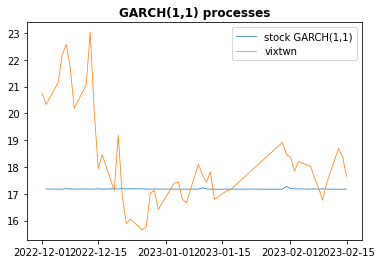

In [283]:
# Estimation using our previously coded classes
modelstock = garchOneOne(log_returns.iloc[1:])

# Fitting using the arch_model package
arch_ms = arch_model(log_returns[1:] * 100, mean = 'Zero', vol = 'GARCH')
arch_ms = arch_ms.fit()

# Extracting confidence intervals
conf_int_stock = pd.DataFrame(arch_ms.conf_int(alpha = .2))

# Creating the test
conf_int_stock['garchOneOne'] = modelstock.coefficients[:-1]
conf_int_stock['Test'] = np.where(conf_int_stock['garchOneOne'] < conf_int_stock['upper'], np.where(conf_int_stock['garchOneOne'] > conf_int_stock['lower'], "Ok", "Not ok"), "Not ok") 

# Transforming data to pandas dataframe
    # + Annualizing volatilities
    # + Indexing by date
dfstock = pd.DataFrame(np.sqrt(modelstock.sigma_2*252), index = log_returns.index[1:])

# Plotting the data
plt.plot(dfstock, label = 'stock GARCH(1,1)', linewidth = .75)
plt.plot(vixtwn, label = 'vixtwn', linewidth = .75)
plt.legend()
plt.title('GARCH(1,1) processes', fontweight = 'bold')

#估計波動率：BS model

In [ ]:
S0 = 15400 # 初始股價
K = 15800 # 歐式買權履約價
T = 1/240 # 到期日所剩時間
r = 0.0117 # 無風險利率
sigma = 0.202 # 波動率

I = 1000000 # 模擬蒙地卡羅幾次
np.random.seed(1000) # 初始化偽隨機變數
z = np.random.standard_t(15,I) # 抽取標準常態分佈隨機亂數
#print(z)

ST = S0 * np.exp((r - sigma ** 2 / 2) *Ｔ + sigma * math.sqrt(T) * z) # 求算到期日股價
#print(ST)

hT = np.maximum(ST - K, 0) # 求算到期日選擇權內含價值
#print(hT)

C0 = math.exp(-r * T) * np.mean(hT) # 求算蒙地卡羅估計值
print('Value of the European call options = {:5.6f}.'.format(C0))

P0 = C0 + math.exp(-r * T) * K - S0
print('Value of the European put options = {:5.6f}.'.format(P0))

Ｎ = 0.5 * C0 / (S0 - math.exp(-r * T) * K) #累積分佈函數

d1 = ((math.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T)))
d2 = ((math.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T)))

value = (S0 * scipy.stats.norm.cdf(d1, 0.0, 1.0) - K * math.exp(-r * T) * scipy.stats.norm.cdf(d2, 0.0, 1.0))
print('{:5.6f}'.format(value))
vega = S0 * scipy.stats.norm.pdf(d1, 0.0, 1.0) * math.sqrt(T)
print('{:5.6f}'.format(vega))
#IV = 0.5 * (27.83 + 27.44)
IV = 0.00
for i in range(10):
    IV -= (value - C0) / vega
    
print('IV of the European call options = {:3.4%}.'.format(IV))
 #隱含波動率

#%run bsm_mcs_euro.py

In [ ]:
class BlackScholesModel(object):
    pass
    def __init__(self):
        pass

#Part 3: 數據分析

In [ ]:
def get_options(option_df, contract_period, put_or_call, strike_price, trade_period):
    
    option_df = option.loc[(option['到期月份(週別)'] == contract_period) & \
                       (option['買賣權'] == put_or_call) & \
                       (option['履約價'] == strike_price) & \
                       (option['交易時段'] == trade_period)]
    return option_df

In [285]:
txo_15400_c = get_options(option, '202302W2', '買權', 15400, '一般')
txo_15500_c = get_options(option, '202302W2', '買權', 15500, '一般')
txo_15600_c = get_options(option, '202302W2', '買權', 15600, '一般')
txo_15700_c = get_options(option, '202302W2', '買權', 15700, '一般')

txo_15400_p = get_options(option, '202302W2', '賣權', 15400, '一般')
txo_15500_p = get_options(option, '202302W2', '賣權', 15500, '一般')
txo_15600_p = get_options(option, '202302W2', '賣權', 15600, '一般')
txo_15700_p = get_options(option, '202302W2', '賣權', 15700, '一般')

In [286]:
# Initialize figure with subplots
fig = make_subplots(
    rows=7, cols=2, subplot_titles=("買權", "賣權")
)

# Add traces
fig.add_trace(go.Scatter(x = txo_15400_c["交易日期"], y = txo_15400_c["收盤價"], name = "買權15400"), row=1, col=1)
fig.add_trace(go.Scatter(x = txo_15500_c["交易日期"], y = txo_15500_c["收盤價"], name = "買權15500"), row=2, col=1)
fig.add_trace(go.Scatter(x = txo_15600_c["交易日期"], y = txo_15600_c["收盤價"], name = "買權15600"), row=3, col=1)
fig.add_trace(go.Scatter(x = txo_15700_c["交易日期"], y = txo_15700_c["收盤價"], name = "買權15700"), row=4, col=1)

fig.add_trace(go.Scatter(x = txo_15400_p["交易日期"], y = txo_15400_p["收盤價"], name = "賣權15400"), row=1, col=2)
fig.add_trace(go.Scatter(x = txo_15500_p["交易日期"], y = txo_15500_p["收盤價"], name = "賣權15500"), row=2, col=2)
fig.add_trace(go.Scatter(x = txo_15600_p["交易日期"], y = txo_15600_p["收盤價"], name = "賣權15600"), row=3, col=2)
fig.add_trace(go.Scatter(x = txo_15700_p["交易日期"], y = txo_15700_p["收盤價"], name = "賣權15700"), row=4, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="15400", row=1, col=2)
fig.update_yaxes(title_text="15500", row=2, col=2)
fig.update_yaxes(title_text="15600", row=3, col=2)
fig.update_yaxes(title_text="15700", row=4, col=2)

# Update title and height
fig.update_layout(title_text="台指選 每日交易行情 - 202302W2", width = 1000, height=2000)

fig.show()

In [287]:
# 設定左右子圖
fig = make_subplots(
    rows = 1, 
    cols = 10, 
    horizontal_spacing = 0.02, 
    subplot_titles = ("2021-11-4 買權", "2021-11-4 賣權", "2021-11-5 買權", "2021-11-5 賣權", "2021-11-8 買權", "2021-11-8 賣權", "2021-11-9 買權", "2021-11-9 賣權", "2021-11-10 買權", "2021-11-10 賣權")
)

## 圖一
# 畫買權長條圖
fig.add_trace(go.Bar(y = call3.index,
                     x = -call3['2023-2-2'],
                     orientation = 'h',
                     name = '2023-2-2 Call',
                     text = ("(" + (call3['2023-2-2'] - call3['2023-2-1']).astype('int').astype('str') + ") " + call3['2023-2-2'].astype('int').astype('str')),
                     marker = dict(color = call3['2023-2-2'], colorscale = 'burg')), 
              row = 1, 
              col = 1)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put3.index,
                     x = put3['2023-2-2'],
                     orientation = 'h',
                     name = '2023-2-2 Put',
                     text = (put3['2023-2-2'].astype('int').astype('str') + " (" + (put3['2023-2-2'] - put3['2023-2-1']).astype('int').astype('str') + ")"),
                     marker = dict(color = put3['2023-2-2'], colorscale = 'darkmint')), 
              row = 1, 
              col = 2)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 1)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 2)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 title_text = "履約價",
                 row = 1, 
                 col = 1)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 2)


## 圖二
# 畫買權長條圖
fig.add_trace(go.Bar(y = call3.index,
                     x = -call3['2023-2-3'],
                     orientation = 'h',
                     name = '2023-2-3 Call',
                     text = ("(" + (call3['2023-2-3'] - call3['2023-2-2']).astype('int').astype('str') + ") " + call3['2023-2-3'].astype('int').astype('str')),
                     marker = dict(color = call3['2023-2-3'], colorscale = 'burg')), 
              row = 1, 
              col = 3)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put3.index,
                     x = put3['2023-2-3'],
                     orientation = 'h',
                     name = '2023-2-3 Put',
                     text = (put3['2023-2-3'].astype('int').astype('str') + " (" + (put3['2023-2-3'] - put3['2023-2-2']).astype('int').astype('str') + ")"),
                     marker = dict(color = put3['2023-2-3'], colorscale = 'darkmint')), 
              row = 1, 
              col = 4)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 3)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 4)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 3)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 4)


## 圖三
# 畫買權長條圖
fig.add_trace(go.Bar(y = call3.index,
                     x = -call3['2023-2-6'],
                     orientation = 'h',
                     name = '2023-2-6 Call',
                     text = ("(" + (call3['2023-2-6'] - call3['2023-2-3']).astype('int').astype('str') + ") " + call3['2023-2-6'].astype('int').astype('str')),
                     marker = dict(color = call3['2023-2-6'], colorscale = 'burg')), 
              row = 1, 
              col = 5)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put3.index,
                     x = put3['2023-2-6'],
                     orientation = 'h',
                     name = '2023-2-6 Put',
                     text = (put3['2023-2-6'].astype('int').astype('str') + " (" + (put3['2023-2-6'] - put3['2023-2-3']).astype('int').astype('str') + ")"),
                     marker = dict(color = put3['2023-2-6'], colorscale = 'darkmint')), 
              row = 1, 
              col = 6)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 5)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 6)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 5)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 6)

## 圖四
# 畫買權長條圖
fig.add_trace(go.Bar(y = call3.index,
                     x = -call3['2023-2-7'],
                     orientation = 'h',
                     name = '2023-2-7 Call',
                     text = ("(" + (call3['2023-2-7'] - call3['2023-2-6']).astype('int').astype('str') + ") " + call3['2023-2-7'].astype('int').astype('str')),
                     marker = dict(color = call3['2023-2-7'], colorscale = 'burg')), 
              row = 1, 
              col = 7)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put3.index,
                     x = put3['2023-2-7'],
                     orientation = 'h',
                     name = '2023-2-7 Put',
                     text = (put3['2023-2-7'].astype('int').astype('str') + " (" + (put3['2023-2-7'] - put3['2023-2-6']).astype('int').astype('str') + ")"),
                     marker = dict(color = put3['2023-2-7'], colorscale = 'darkmint')), 
              row = 1, 
              col = 8)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 7)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 8)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 7)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 8)

## 圖五
# 畫買權長條圖
fig.add_trace(go.Bar(y = call3.index,
                     x = -call3['2023-2-8'],
                     orientation = 'h',
                     name = '2023-2-8 Call',
                     text = ("(" + (call3['2023-2-8'] - call3['2023-2-7']).astype('int').astype('str') + ") " + call3['2023-2-8'].astype('int').astype('str')),
                     marker = dict(color = call3['2023-2-8'], colorscale = 'burg')), 
              row = 1, 
              col = 9)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put3.index,
                     x = put3['2023-2-8'],
                     orientation = 'h',
                     name = '2023-2-8 Put',
                     text = (put3['2023-2-8'].astype('int').astype('str') + " (" + (put3['2023-2-8'] - put3['2023-2-7']).astype('int').astype('str') + ")"),
                     marker = dict(color = put3['2023-2-8'], colorscale = 'darkmint')), 
              row = 1, 
              col = 10)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 9)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 10)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 9)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 10)

# 設定圖的標題跟長寬
fig.update_layout(title_text = "臺指選擇權[202302W2] 未沖銷契約數 支撐壓力圖", 
                  width = 2400, 
                  height = 1300)

fig.show()

#測試測試

In [ ]:
import numpy as np
import scipy
import pandas as pd
!pip install yfinance
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns * 100
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return np.append(opt.x, variance)

# Downloading data
import yfinance as yf
SPX = yf.download('^GSPC', start = '2005-01-01', interval = '1d')

VIX = yf.download('^VIX', start = SPX.index[1], interval = '1d')
# Calculating log returns
SPX['log_returns'] = np.log(SPX['Adj Close']) - np.log(SPX['Adj Close'].shift(1))


from arch import arch_model
# Estimation using our previously coded classes
modelSPX = garchOneOne(SPX['log_returns'][1:])

# Fitting using the arch_model package
arch_mSPX = arch_model(SPX['log_returns'][1:] * 100, mean = 'Zero', vol = 'GARCH')
arch_mSPX = arch_mSPX.fit()

# Extracting confidence intervals
conf_int_SPX = pd.DataFrame(arch_mSPX.conf_int(alpha = .05))

# Creating the test
conf_int_SPX['garchOneOne'] = modelSPX.coefficients[:-1]
#conf_int_CAC['garchOneOne'] = modelCAC.coefficients[:-1]
conf_int_SPX['Test'] = np.where(conf_int_SPX['garchOneOne'] < conf_int_SPX['upper'], np.where(conf_int_SPX['garchOneOne'] > conf_int_SPX['lower'], "Ok", "Not ok"), "Not ok") 
#conf_int_CAC['Test'] = np.where(conf_int_CAC['garchOneOne'] < conf_int_CAC['upper'], np.where(conf_int_CAC['garchOneOne'] > conf_int_CAC['lower'], "Ok", "Not ok"), "Not ok")

import matplotlib.pyplot as plt
%matplotlib inline
# Transforming data to pandas dataframe
    # + Annualizing volatilities
    # + Indexing by date
dfSPX = pd.DataFrame(np.sqrt(modelSPX.sigma_2*252), index = SPX.index[1:])
#dfCAC = pd.DataFrame(np.sqrt(modelCAC.sigma_2*252), index = CAC.index[1:])
# Plotting the data
plt.plot(dfSPX, label = 'SPX GARCH(1,1)', linewidth = .25)
#plt.plot(dfCAC, label = 'CAC GARCH(1,1)', linewidth = .25)
plt.plot(VIX.Close, label = 'VIX', linewidth = .25)
plt.legend()
plt.title('GARCH(1,1) processes and VIX', fontweight = 'bold')

In [234]:
print(log_returns)
print(arch_ms)
print(conf_int_stock)
print(dfstock)
print(SPX)
print(arch_mSPX)
print(conf_int_SPX)
print(dfSPX)

日期
2023-01-03         NaN
2023-01-04   -0.001758
2023-01-05    0.007152
2023-01-06    0.005042
2023-01-09    0.026018
2023-01-10    0.003434
2023-01-11   -0.003486
2023-01-12   -0.001343
2023-01-13    0.006259
2023-01-16    0.006916
2023-01-17    0.000397
2023-01-30    0.036872
2023-01-31   -0.014866
2023-02-01    0.010098
2023-02-02    0.011287
2023-02-03    0.000481
2023-02-06   -0.013540
2023-02-07    0.000525
2023-02-08    0.014008
2023-02-09   -0.001247
2023-02-10   -0.000773
2023-02-13   -0.002722
2023-02-14    0.007064
2023-02-15   -0.014256
Name: log_returns, dtype: float64
                       Zero Mean - GARCH Model Results                        
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.043
Vol Model:                      GARCH   Log-Likelihood:               -36.8674
Distribution:                  Normal   AIC:                           79.7347
Method:         